# Motivation
compare NBLAST clustering and Ashwin's clustering

In [22]:
using Revise
using CSV
using DataFrames
using JLD2
using RealNeuralNetworks.Neurons
using RealNeuralNetworks.Neurons.Segments
using RealNeuralNetworks.NBLASTs
using RealNeuralNetworks.NeuralNets
using JuliaDB 

using ProgressMeter
using Clustering

const DATASET_DATE = "20190415"

"20190415"

# Read manual clustering

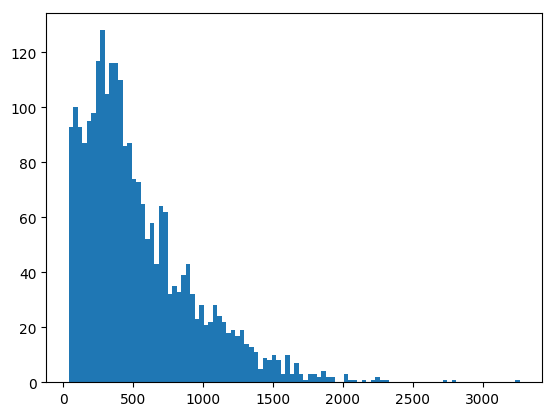

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[28]:3
└ @ Core In[28]:3


([93.0, 100.0, 93.0, 87.0, 95.0, 98.0, 117.0, 128.0, 105.0, 116.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [40.1179, 72.3563, 104.595, 136.833, 169.072, 201.31, 233.549, 265.787, 298.025, 330.264  …  2973.82, 3006.05, 3038.29, 3070.53, 3102.77, 3135.01, 3167.25, 3199.48, 3231.72, 3263.96], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6aca58>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6ac860>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6acd30>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6b50b8>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6b5400>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6b5748>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6b5a90>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6b5dd8>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6bb160>, PyObject <matplotlib.patches.Rectangle object at 0x7f2c3a6bb4a8>  …  PyObject <matplotlib.pa

In [28]:
db = JuliaDB.loadtable("../01_data/$DATASET_DATE/features.csv")
totalPathLengthList = select(db, :totalPathLength)
PyPlot.plt[:hist](totalPathLengthList./1000, bins=100)

In [29]:
tpl = totalPathLengthList |> sum 
tpl /= 1e6
tpl / 24

56.327680956416664

In [30]:
# read Ashwin's clustering

df = CSV.read("../01_data/groundtruth/ManualSorting_Ashwin.csv", sink=NamedTuple; datarow=3) 

typeName2neuronIdList = Dict{Symbol, Vector{Int}}()

for name in names(df)
    if name in Set([Symbol("Misc/Cblm"), :Intersting, :divingAxons])
        # skip some unreliable neurons
        continue
    end
    v = df[name]
    v = v[.!ismissing.(v)]
    
    typeName2neuronIdList[name] = v
end
# typeName2neuronIdList


manualNeuronId2labelId = Dict{Int, Int}()
for (typeId, neuronIdList) in typeName2neuronIdList |> values |> enumerate
    for neuronId in neuronIdList
        manualNeuronId2labelId[ neuronId ] = typeId
    end
end

manualTypeId2Name = Dict{Int, Symbol}()
for (typeId, typeName) in typeName2neuronIdList |> keys |> enumerate
    manualTypeId2Name[ typeId ] = typeName
end

# manualNeuronId2Label = Dict{Int, Symbol}()
# for (typeName, neuronIdList) in typeName2neuronIdList
#     for neuronId in neuronIdList
#         manualNeuronId2Label[ neuronId ] = typeName
#     end
# end

@show length(manualNeuronId2labelId)
manualNeuronId2labelId

typeName2neuronIdList

length(manualNeuronId2labelId) = 212


Dict{Symbol,Array{Int64,1}} with 17 entries:
  Symbol("ABDc?")           => [77125, 77128, 77135, 77153, 77231, 77247, 78685…
  :ipsi2                    => [78465, 78466]
  :ABDiR                    => [77631, 77150, 77618, 77886, 78547, 77158, 78556…
  :Column4                  => [77342, 77352, 77336, 77354, 77373, 78346, 77433…
  Symbol("Lateral/ Ventral… => [80163, 80167, 80177, 80179, 76688, 80204, 80206…
  :Sparse                   => [76540, 76622, 76626, 76697, 76748, 76750, 76751…
  :AbdC                     => [77154, 77646, 77682, 77628, 77295, 77297, 77652…
  Symbol("Lateral/ Dorsal") => [76629, 76667, 80185, 76691, 76692, 77357, 77389…
  :Bushy                    => [76618, 76625, 76627, 77132, 77162, 77163, 77329…
  Symbol("unknown types")   => [78391, 78434, 78438, 78440, 78447, 78448, 78450…
  :Triangle                 => [76749, 76752, 77142, 77369, 77374, 77446, 77455…
  :Vestibular               => [76631, 76700, 76656, 76655, 76660, 76679, 77393…
  :ABDiC          

# Read Clustering from R NBlast

In [31]:
# # read NBLAST clustering
# DIR = "../01_data/$(DATASET_DATE)/"
# df = CSV.read(joinpath(DIR, "nblast_fullNeuron_memb_15_types.csv"))

# nblastNeuronIdList = map(x->Meta.parse(replace(x, ".swc"=>"")), df[:Column1])
# nblastLabelList = df[:x]

# nblastNeuronId2Label = Dict{Int, Int}()
# for (i, neuronId) in enumerate(nblastNeuronIdList)
#     nblastNeuronId2Label[ neuronId ] = nblastLabelList[i]
# end

# @show length(nblastNeuronId2Label)
# nblastNeuronId2Label

## Compare with manual clustering

In [48]:
# # find the neuronId intersection of two clustering
# commonNeuronIdSet = Set(keys(manualNeuronId2Label)) ∩ Set(keys(nblastNeuronId2Label))
# @show length(commonNeuronIdSet)
# # get the label list of manual and nblast clustering
# manualLabelList = Vector{Int}()
# nblastLabelList = Vector{Int}()
# for neuronId in commonNeuronIdSet
#     manualLabel = manualNeuronId2Label[ neuronId ]
#     nblastLabel = nblastNeuronId2Label[ neuronId ]
#     push!(manualLabelList, manualLabel)
#     push!(nblastLabelList, nblastLabel)
# end

# # evaluate the clustering quantitatively using rand index and rand error
# using Clustering

# @show adjustedRandIndex, randIndex, mirkinIndex, hubertIndex = Clustering.randindex(manualLabelList, nblastLabelList)

UndefVarError: UndefVarError: manualNeuronId2Label not defined

In [33]:
# ## show the two labeling results
# manualLabelId2commonNeuronIdList = Dict{Int, Vector{Int}}()
# nblastLabelId2commonNeuronIdList = Dict{Int, Vector{Int}}()
# for neuronId in commonNeuronIdSet
#     manualLabel = manualNeuronId2Label[ neuronId ]
#     nblastLabel = nblastNeuronId2Label[ neuronId ]
#     if !haskey( manualLabelId2commonNeuronIdList, manualLabel )
#         manualLabelId2commonNeuronIdList[ manualLabel ] = Vector{Int}()
#     end
#     if !haskey( nblastLabelId2commonNeuronIdList, nblastLabel )
#         nblastLabelId2commonNeuronIdList[ nblastLabel ] = Vector{Int}()
#     end
    
#     push!(manualLabelId2commonNeuronIdList[ manualLabel ], neuronId) 
#     push!(nblastLabelId2commonNeuronIdList[ nblastLabel ], neuronId) 
# end

# println("manual clustering: ")
# for (labelId, neuronIdList) in manualLabelId2commonNeuronIdList
#     labelName = manualTypeId2Name[ labelId ]
#     println(labelId, " => ", labelName, " => ", neuronIdList)
# end

# println("\n \nnblast clustering: ")
# for (labelId, neuronIdList) in nblastLabelId2commonNeuronIdList
#     println(labelId, " => ", neuronIdList)
# end
# # @show manualLabelId2commonNeuronIdList
# # @show nblastLabelId2commonNeuronIdList

# Read clustering based on Julia NBLAST

In [34]:
# @load "../01_data/$(DATASET_DATE)/postprocessed/neuronId2labelId.jld" neuronId2labelId 

### get neuron id list and neuron list

In [35]:
# typeNameList = Symbol[:AbdR, :AbdC, :ABDiR, :ABDiC]

# # neuronIdList = Vector{Int}()
# neuronList = Vector{Neuron}()

# @showprogress for typeName in typeNameList
#     for neuronId in typeName2neuronIdList[typeName]
#         if isfile("../01_data/$(DATASET_DATE)/postprocessed/bin/$(neuronId).bin")
#             neuron = Neurons.load("../01_data/$(DATASET_DATE)/postprocessed/bin/$(neuronId).bin")
# #             neuron = Neurons.resample(neuron, Float32(1000))
#             push!(neuronList, neuron)
# #             push!(neuronIdList, neuronId)
#         end
#     end
# end
# println("length of neuron id list: ", length(neuronIdList))

using JuliaDB

db = JuliaDB.loadtable("../01_data/$(DATASET_DATE)/features.csv")
neuronIdList = select(db, :neuronId)

2512-element Array{Int64,1}:
 81139
 76497
 78406
 77672
 79475
 79072
 77902
 78953
 78979
 77449
 76455
 77504
 79323
     ⋮
 77025
 77938
 78426
 79772
 76868
 80318
 78061
 80330
 80354
 76270
 78804
 78447

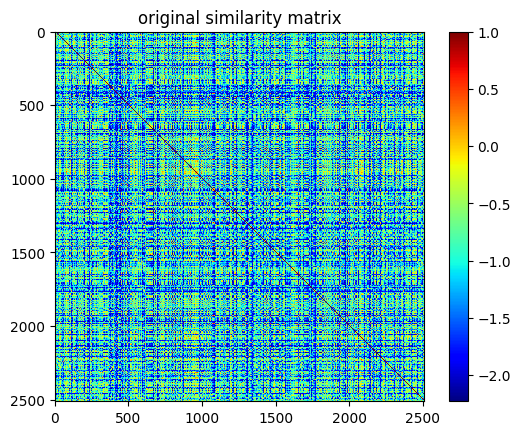

PyObject Text(0.5, 1.0, 'original similarity matrix')

In [36]:
# using Pkg
# using RealNeuralNetworks.Utils.RangeIndexingArrays
# # df = CSV.read(joinpath(Pkg.devdir(), "RealNeuralNetworks/asset/zfish_score_table.csv"))
# df = CSV.read(joinpath(Pkg.devdir(), "RealNeuralNetworks/asset/smat_fcwb.csv"))
# # df = CSV.read(joinpath(Pkg.devdir(), "RealNeuralNetworks/asset/smat_alpha.fcwb.csv"))
# ria = RangeIndexingArray{Float32}(df)
# @time similarityMatrix =NBLASTs.nblast_allbyall(neuronList; ria=ria, normalisation=:mean)
JLD2.@load "../01_data/$(DATASET_DATE)/similarityMatrix.jld2" similarityMatrix

using PyPlot
PyPlot.imshow(similarityMatrix, interpolation="nearest", cmap="jet")
PyPlot.colorbar()
PyPlot.title("original similarity matrix")

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[37]:4
└ @ Core In[37]:4
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[37]:5
└ @ Core In[37]:5


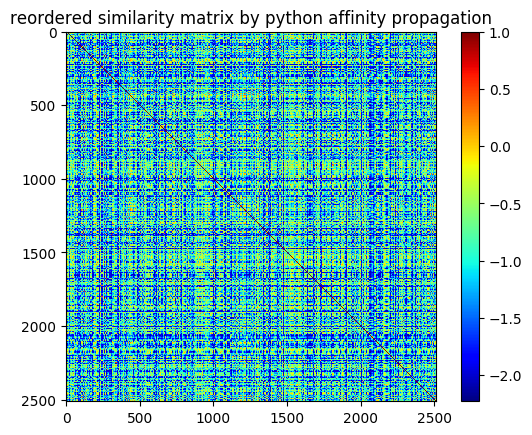

classified 2512 neurons to 152 groups


PyObject Text(0.5, 1.0, 'reordered similarity matrix by python affinity propagation')

In [37]:
using PyCall
S = similarityMatrix
@pyimport sklearn.cluster as cl
af = cl.AffinityPropagation(affinity="precomputed")[:fit]( S )
ref_assignments = af[:labels_] .+ 1

labels = ref_assignments

println("classified ", size(similarityMatrix,1)," neurons to ", maximum(labels), " groups")

orders = NeuralNets.labels2orders(labels)

reorderedSimilarityMatrix = NeuralNets.reorder_matrix(similarityMatrix, orders)

PyPlot.imshow(reorderedSimilarityMatrix, interpolation="nearest", cmap="jet")
PyPlot.colorbar()
PyPlot.title("reordered similarity matrix by python affinity propagation")

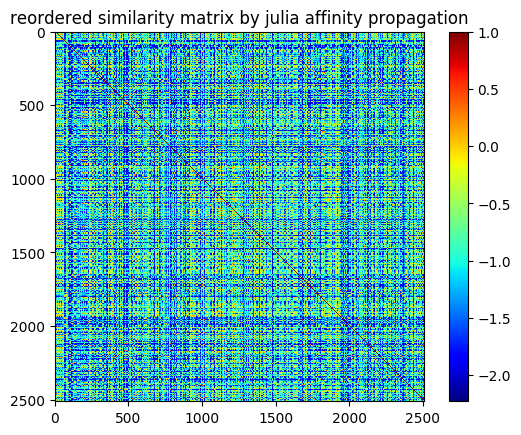

classified 2512 neurons to 152 groups


PyObject Text(0.5, 1.0, 'reordered similarity matrix by julia affinity propagation')

In [38]:
# modify the diagno with median values
using Statistics
adjustedSimilarityMatrix = copy(similarityMatrix)
m = median(similarityMatrix)
for i in 1:size(similarityMatrix,1)
    adjustedSimilarityMatrix[i,i] = m
end
ap = Clustering.affinityprop(adjustedSimilarityMatrix)

println("classified ", size(similarityMatrix,1)," neurons to ", maximum(ap.assignments), " groups")
apOrders = NeuralNets.labels2orders(ap.assignments)

reorderedSimilarityMatrix = NeuralNets.reorder_matrix(similarityMatrix, apOrders)

PyPlot.imshow(reorderedSimilarityMatrix, interpolation="nearest", cmap="jet")
PyPlot.colorbar()
PyPlot.title("reordered similarity matrix by julia affinity propagation")

### hierarchical clustering 

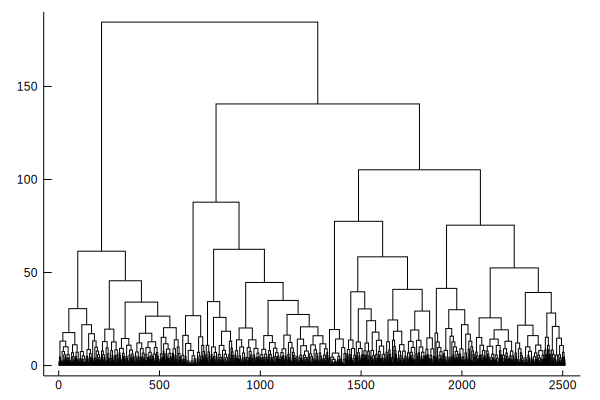

In [39]:
using Clustering

distanceMatrix = 1.0 .- similarityMatrix
# distanceMatrix = distanceMatrix .* distanceMatrix
hc = hclust(distanceMatrix, linkage=:ward)

using Pkg
include(joinpath(Pkg.devdir(), "RealNeuralNetworks/src/Utils/PlotRecipes.jl"))
using .PlotRecipes
PlotRecipes.plot(hc)

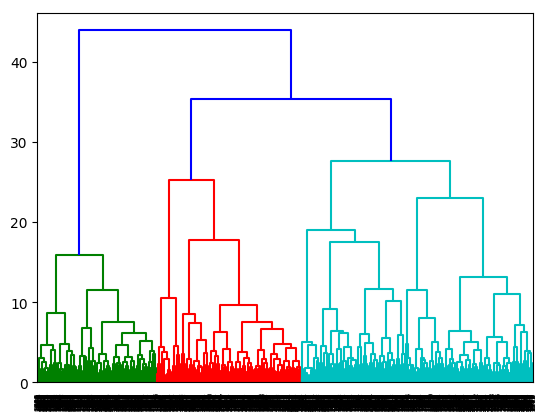

Dict{Any,Any} with 5 entries:
  "leaves"     => [466, 1862, 2255, 79, 2410, 1667, 2254, 261, 2124, 118  …  18…
  "icoord"     => [15.0 15.0 25.0 25.0; 5.0 5.0 20.0 20.0; … ; 7800.61 7800.61 …
  "ivl"        => ["466", "1862", "2255", "79", "2410", "1667", "2254", "261", …
  "dcoord"     => [0.0 0.372195 0.372195 0.0; 0.0 0.631302 0.631302 0.372195; ……
  "color_list" => ["g", "g", "g", "g", "g", "g", "g", "g", "g", "g"  …  "c", "c…

In [40]:
# construct condensed distance matrix for python
# the condensed distance matrix is a matrix with the upper diagnal of the distance matrix
N = size(distanceMatrix,1)
condensedDistanceMatrix = Vector{Float32}(undef, div(N*(N-1),2)) 

k = 0
for i in 1:N
    for j in i+1:N
        k += 1
        condensedDistanceMatrix[k] = distanceMatrix[i,j]
    end
end

condensedDistanceMatrix

@pyimport scipy.cluster.hierarchy as pyhierarchy

Z = pyhierarchy.ward(condensedDistanceMatrix)

dn = pyhierarchy.dendrogram(Z)


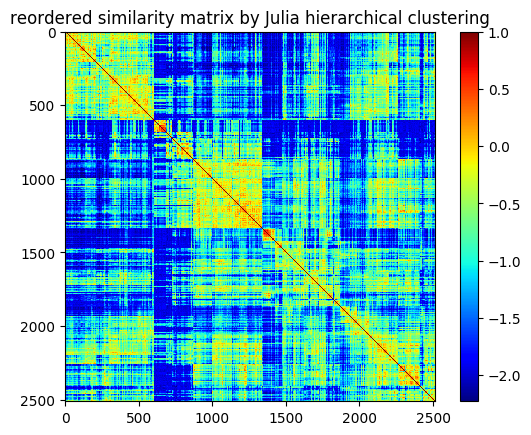

PyObject Text(0.5, 1.0, 'reordered similarity matrix by Julia hierarchical clustering')

In [41]:
reorderedSimilarityMatrix = NeuralNets.reorder_matrix(similarityMatrix, hc.order)

PyPlot.imshow(reorderedSimilarityMatrix, interpolation="nearest", cmap="jet")
PyPlot.colorbar()
PyPlot.title("reordered similarity matrix by Julia hierarchical clustering")

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[42]:4
└ @ Core In[42]:4
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[42]:5
└ @ Core In[42]:5


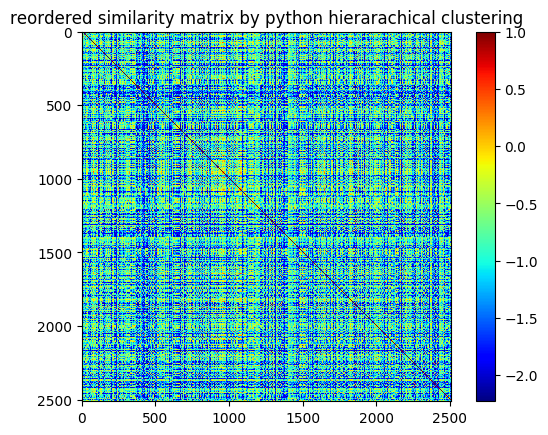

classificed 2512 neurons into 2 groups


PyObject Text(0.5, 1.0, 'reordered similarity matrix by python hierarachical clustering')

In [42]:
using PyCall

@pyimport sklearn.cluster as cluster
clustering = cluster.AgglomerativeClustering(affinity="precomputed", linkage="average")[:fit](1.0 .- similarityMatrix)

labels = clustering[:labels_] .+ 1

println("classificed ", size(similarityMatrix,1), " neurons into ", maximum(labels), " groups")

orders = NeuralNets.labels2orders(labels)

reorderedSimilarityMatrix = NeuralNets.reorder_matrix(similarityMatrix, orders)

PyPlot.imshow(reorderedSimilarityMatrix, interpolation="nearest", cmap="jet")
PyPlot.colorbar()
PyPlot.title("reordered similarity matrix by python hierarachical clustering")

## Compare with manual clustering

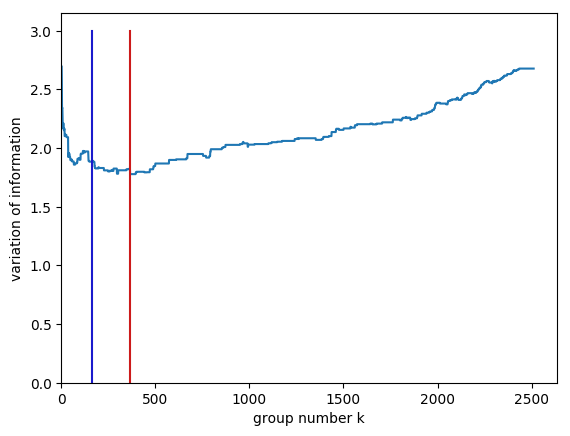

classified to 366 groups will have maximum score: 1.7778239200500607


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2c81d5d5c0>

In [43]:
using Clustering
function evaluate_clustering(neuronId2labelId::Dict{Int,Int}; 
                                manualNeuronId2labelId::Dict{Int,Int}=manualNeuronId2labelId)
    # find the neuronId intersection of two clustering
    commonNeuronIdSet = Set(keys(manualNeuronId2labelId)) ∩ Set(keys(neuronId2labelId))
#     println("total number of common neurons: ", length(commonNeuronIdSet))

    # get the label list of manual and nblast clustering
    manualLabelList = Vector{Int}()
    nblastLabelList = Vector{Int}()
    for neuronId in commonNeuronIdSet
        manualLabel = manualNeuronId2labelId[ neuronId ]
        nblastLabel = neuronId2labelId[ neuronId ]
        push!(manualLabelList, manualLabel)
        push!(nblastLabelList, nblastLabel)
    end

    # evaluate the clustering quantitatively using rand index and rand error
#     adjustedRandIndex, randIndex, mirkinIndex, hubertIndex = Clustering.randindex(manualLabelList, nblastLabelList)
#     return adjustedRandIndex
#     return randIndex
#     @assert length(unique(manualLabelList)) == maximum(manualLabelList)
    
    # reassign label id
    oldLabelId2newLabelId = Dict{Int,Int}()
    for (newLabelId, oldLabelId) in unique(nblastLabelList) |> enumerate
        oldLabelId2newLabelId[ oldLabelId ] = newLabelId
    end
    for (i, oldLabelId) in nblastLabelList |> enumerate
        nblastLabelList[i] = oldLabelId2newLabelId[oldLabelId]
    end
    
#     @show length(unique(nblastLabelList)), maximum(nblastLabelList)
    @assert length(unique(nblastLabelList)) == maximum(nblastLabelList)
    return Clustering.varinfo(maximum(manualLabelList), manualLabelList, maximum(nblastLabelList), nblastLabelList)
end


function evaluate_clustering(labelIdList::Vector{Int}; neuronIdList::Vector{Int}=neuronIdList, 
                        manualNeuronId2labelId::Dict{Int,Int}=manualNeuronId2labelId)
    neuronId2labelId = Dict{Int,Int}()
    for (i, neuronId) in neuronIdList |> enumerate
        neuronId2labelId[neuronId] = labelIdList[i]
    end

    return evaluate_clustering(neuronId2labelId; manualNeuronId2labelId=manualNeuronId2labelId)
end

kList = 2:length(neuronIdList)-1
scoreList = Vector{Float64}()
for k in kList
    labelIdList = cutree(hc; k=k)
    score = evaluate_clustering(labelIdList)
    push!(scoreList, score)
end

PyPlot.plot(kList, scoreList)
PyPlot.xlabel("group number k")
PyPlot.ylabel("variation of information")
# PyPlot.ylabel("rand index")

maxScore, mri = findmin(scoreList)
println("classified to ", kList[mri], " groups will have maximum score: ", maxScore)
PyPlot.plot([kList[mri], kList[mri]], [0,3], c=(0.8,0.1,0.1))
PyPlot.xlim(0,)
PyPlot.ylim(0,)

PyPlot.plot([163, 163], [0,3], c=(0.1,0.1,0.8))

In [44]:
# PyPlot.plot(kList, scoreList)
# PyPlot.xlabel("group number k")
# PyPlot.ylabel("variation of information")

# maxScore, mri = findmin(scoreList)
# println("classified to ", kList[mri], " groups will have maximum score: ", maxScore)
# PyPlot.plot([kList[mri], kList[mri]], [0,3], c=(0.8,0.1,0.1))
# PyPlot.xlim(0,300)
# PyPlot.ylim(0,)

# PyPlot.plot([163, 163], [0,3], c=(0.1,0.1,0.8))

In [45]:
commonNeuronIdSet = Set(keys(manualNeuronId2labelId)) ∩ Set(neuronIdList)
println("total number of manual classfied neurons: ", length(manualNeuronId2labelId))
println("total number of analysized neurons: ", length(neuronIdList))
println("total number of common neurons: ", length(commonNeuronIdSet))

total number of manual classfied neurons: 212
total number of analysized neurons: 2512
total number of common neurons: 208


In [46]:
evaluate_clustering(Vector(1:length(neuronIdList)))

2.6773788499086777

In [47]:
labelIdList = cutree(hc; k=163)

for labelId in 1:maximum(labelIdList)
    idxes = findall(labelIdList .== labelId)
#     @show idxes
    println("label ", labelId, " ==> ", neuronIdList[idxes])
end

label 1 ==> [81139, 80526, 78654, 80635, 80640, 78635, 80639, 78678, 80888, 80889, 80710, 78652]
label 2 ==> [76497, 76542, 76191, 76530, 77940, 76537, 76496, 77929, 77939, 77928, 77938]
label 3 ==> [78406, 78634, 79892, 79878, 81755, 78421, 77903, 79922, 79825, 79886, 81792, 79920, 80286, 80305, 78359, 78355, 77822]
label 4 ==> [77672, 77654, 77628, 78854, 77688, 81643, 77296, 80700, 80868, 77705, 77891, 77305, 77661, 77303, 77689, 82197, 77682, 80759, 77662, 77300, 77154, 77292, 77301, 80707, 77295, 77658, 77652, 82212, 80757, 77657, 81172, 77684, 77648, 80542, 80675, 77709, 81169]
label 5 ==> [79475, 79426, 78091, 79418, 79537, 79409, 79309, 79436, 79417, 79530, 76570, 79443, 79576, 79403, 79457, 77262, 79320, 77259, 79433, 77260, 79544, 79395, 79543, 79542, 77442, 76606, 78092, 79422, 79440, 79453]
label 6 ==> [79072, 81574, 79067, 77778, 79062, 78657, 78646, 78680, 77140, 77748, 79055, 78615, 81528, 78682, 78576, 77779, 79074, 81028, 79069, 77621, 80955, 79058, 77146, 79064, 77127

label 131 ==> [80275, 76473, 76475, 76406]
label 132 ==> [81587, 81494, 81116, 81064, 80652, 80887, 81061, 80164, 80664, 80166, 81592, 80648, 77391, 80245, 78677, 78850, 81081, 81496, 81539, 81058, 81588, 81490]
label 133 ==> [79280, 78065, 78064, 78063, 78061]
label 134 ==> [79944, 79747, 78124, 78889, 79945, 78896, 78901, 81605, 79961, 79400, 78827, 78127]
label 135 ==> [81868, 79737, 79871, 79224, 80841, 79963, 81751, 79243, 79968, 79823, 81750, 81414, 79744, 78886]
label 136 ==> [78965, 81642, 81449, 81631, 80340, 79261, 81429, 80753, 81676]
label 137 ==> [79339, 77022, 79343, 79269, 77048, 76918, 78062, 81425, 79324, 79344, 79575]
label 138 ==> [79880, 79226, 78140, 81305, 78172, 78810, 78777, 78813, 79813, 79956, 78776, 79161, 79812, 78808, 76925, 79718, 78778]
label 139 ==> [80470, 81687, 80879, 80796, 81659, 80718, 81544, 81542, 77782, 80877, 81541, 78054, 79807, 81684, 81657, 78855, 81497, 80873, 81688, 79937]
label 140 ==> [78762, 76844, 77870, 78294, 82164, 81498]
label 141 